In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2

from keras.models import Model,load_model
from keras.applications.inception_resnet_v2 import preprocess_input
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix

2023-01-24 22:01:42.748887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 22:01:42.818355: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-24 22:01:43.144307: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mehathab/miniconda3/envs/corn_dev/lib/python3.8/site-packages/cv2/../../lib64::/home/mehatha

In [2]:
test_dir = 'test/'
image_names = os.listdir(test_dir)
classes = ['Healthy', 'Sprayable', 'Non Sprayable' ]

In [3]:
# test_dict = {'image_path':[],
#             'classification':[]}

# for i,name in enumerate(image_names):
#     name_split = name.split("_")
#     class_name = ''
#     if name_split[0] == "Non":
#         class_name = name_split[0]+" "+name_split[1]
#     else:
#         class_name = name_split[0]
        
#     test_dict['image_path'].append(test_dir+name)
#     test_dict['classification'].append(classes.index(class_name))

# test_dict = pd.DataFrame(test_dict)
# test_dict.to_csv("test.csv")

In [4]:
test_csv = pd.read_csv('test.csv')

In [5]:
x_test = test_csv['image_path']
y_test = test_csv['classification']

In [6]:
def contrast(img):
    # Contrast Streching
    img = img.astype('uint8')
    original = img.copy()
    xp = [0, 64, 128, 192, 255]
    fp = [0, 16, 128, 240, 255]
    x = np.arange(256)
    table = np.interp(x, xp, fp).astype('uint8')
    img = cv2.LUT(img, table)    
    return preprocess_input(img)

def colorspace(img, space):
    image = img.astype('uint8')
    
    if space =='HLS':
        print("HLS")
        img_convert = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        img_convert = preprocess_input(img_convert)
    elif space =='RGB':
        print("RGB")
        img_convert = image
        img_convert = contrast(img_convert)
    elif space =='BGR':
        print("BGR")
        img_convert = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        img_convert = contrast(img_convert)
    elif space =='LUV':
        print("LUV")
        img_convert = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        img_convert = contrast(img_convert)
    elif space =='LAB':
        print("LAB")
        img_convert = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        img_convert = contrast(img_convert)
    elif space =='HSV':
        print("HSV")
        img_convert = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        img_convert = contrast(img_convert)
    else:
        img_convert = preprocess_input(image)
        
    return img_convert.astype('float32')

In [7]:
def resized(img,space):
    image = plt.imread(img)
    image_colorspace = colorspace(image, space)    
    img_resize = resize(image_colorspace,(299,299,3))
    img_expand = np.expand_dims(img_resize, axis=0)
    return img_expand
    

In [8]:
def model_predictor(img, model_name):
    predict_list = []
    predict_prob = []

    for i, model in enumerate(models):
        print("Space:",model_name[i])
        image_processed = resized(img, model_name[i])
        predictions = model.predict(image_processed)
        flatten_predictions = list(predictions.flatten())
        predict_prob.append(flatten_predictions)

    predict_prob = list(np.mean(predict_prob, axis=0))
    print("Probs :",predict_prob)

    sort_predictions = np.sort(np.array(predict_prob), axis=0)
    sort_predictions = sort_predictions[::-1]

    main_predict = predict_prob.index(sort_predictions[0])
    second_predict = predict_prob.index(sort_predictions[1])
    third_predict = predict_prob.index(sort_predictions[2])

    if sort_predictions[0]:
        predict_list.append(main_predict)
    if sort_predictions[1] and (sort_predictions[0] * 10 < 9.5) and (sort_predictions[1] * 100 > 1):
        predict_list.append(second_predict)
    if (sort_predictions[1] - sort_predictions[2] < 0.05) and (sort_predictions[2] * 100 > 1):
        predict_list.append(third_predict)

    return [predict_list, predict_prob]

In [9]:
def predictor(image,space):
        predict, pred_prob = model_predictor(image,space)
        predicted_classes = [classes[i] for i in predict]
        return [predicted_classes, pred_prob]

<hr>

### RGB + HSV + HSL

#### Normal Weights

In [10]:
model1 = load_model('models/IncRes_RGB_model1.hdf5')
model1.load_weights('best_weights/IncRes_RGB_model1.hdf5')
model2 = load_model('models/IncRes_HSV+Contrast_model1.hdf5')
model2.load_weights('best_weights/IncRes_HSV+Contrast_model1.hdf5')
model3 = load_model('models/IncRes_HLS_model1.hdf5')
model3.load_weights('best_weights/IncRes_HLS_model1.hdf5')
models = [model1, model2, model3]
model_space = ['RGB', 'HSV', 'HLS']

2023-01-24 22:01:51.755239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 22:01:51.759072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 22:01:51.759519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 22:01:51.760102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [11]:
y_pred = []
counter = 0
for i,image_path in enumerate(x_test):
    probs = []       
    predictions,preds = predictor(image_path,model_space)  
    c = 0    
    for j,pred in enumerate(predictions):
        class_pred = classes.index(pred)  
        print("True:",classes[y_test[i]]," Predicted:",pred)
        if classes[y_test[i]] == pred:
            print("True:",classes[y_test[i]]," Predicted:",pred,class_pred)
            y_pred.append(class_pred)
            c = 1
            counter += 1
            break
    if c == 0:
        y_pred.append(classes.index(predictions[0]))
print("counter",counter,"/ 30")

Space: RGB
RGB


2023-01-24 22:02:04.046487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-24 22:02:04.487284: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-24 22:02:04.487641: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-24 22:02:04.487647: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-24 22:02:04.488086: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-24 22:02:04.488121: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step


2023-01-24 22:02:05.656038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Space: HSV
HSV
1/1 [==============================] - 1s 1s/step
Space: HLS
HLS
1/1 [==============================] - 1s 1s/step
Probs : [0.9965213, 0.00060035946, 0.0028782787]
True: Healthy  Predicted: Healthy
True: Healthy  Predicted: Healthy 0
Space: RGB
RGB
1/1 [==============================] - 0s 22ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 20ms/step
Space: HLS
HLS
1/1 [==============================] - 0s 20ms/step
Probs : [0.5904469, 0.009016371, 0.40053678]
True: Sprayable  Predicted: Healthy
True: Sprayable  Predicted: Non Sprayable
Space: RGB
RGB
1/1 [==============================] - 0s 21ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 20ms/step
Space: HLS
HLS
1/1 [==============================] - 0s 20ms/step
Probs : [0.032919794, 0.19966692, 0.7674133]
True: Non Sprayable  Predicted: Non Sprayable
True: Non Sprayable  Predicted: Non Sprayable 2
Space: RGB
RGB
1/1 [==============================] - 0s 22ms/step
Space: HSV
HSV
1/1 [

Space: HLS
HLS
1/1 [==============================] - 0s 21ms/step
Probs : [2.7320718e-06, 0.8115611, 0.1884362]
True: Sprayable  Predicted: Sprayable
True: Sprayable  Predicted: Sprayable 1
Space: RGB
RGB
1/1 [==============================] - 0s 22ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 22ms/step
Space: HLS
HLS
1/1 [==============================] - 0s 21ms/step
Probs : [0.4863665, 0.1662681, 0.34736538]
True: Sprayable  Predicted: Healthy
True: Sprayable  Predicted: Non Sprayable
Space: RGB
RGB
1/1 [==============================] - 0s 20ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 21ms/step
Space: HLS
HLS
1/1 [==============================] - 0s 20ms/step
Probs : [0.9893213, 0.0011286516, 0.009550055]
True: Healthy  Predicted: Healthy
True: Healthy  Predicted: Healthy 0
Space: RGB
RGB
1/1 [==============================] - 0s 20ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 21ms/step
Space: HLS
HLS
1/1 [===============

RGB NormalWeights
Accuracy : 0.8 

              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.45      0.62        11
           2       0.80      1.00      0.89        12

    accuracy                           0.80        30
   macro avg       0.83      0.82      0.78        30
weighted avg       0.85      0.80      0.78        30



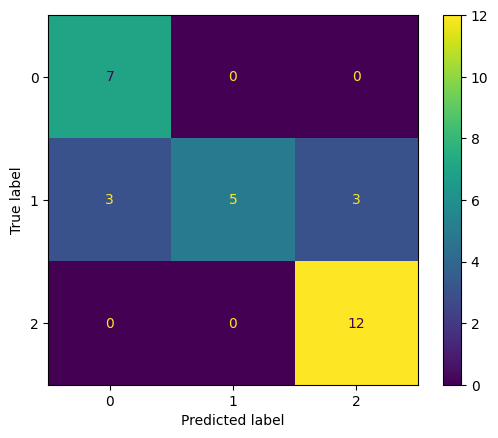

In [12]:
acc = accuracy_score(y_true=y_test, y_pred=y_pred)

confusion = ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred)).plot()

print("RGB NormalWeights")
print("Accuracy :",acc,"\n")
print(classification_report(y_true=y_test, y_pred=y_pred))
# plt.savefig("confusionmatrix_RGB_model1.png")

In [13]:
print("Predicted",y_pred)
print("True     ",list(y_test))

Predicted [0, 0, 2, 2, 2, 0, 0, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 0, 1, 0, 2, 2]
True      [0, 1, 2, 2, 2, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 0, 1, 2]


### BGR + HSV + HSL

In [14]:
model1 = load_model('models/IncRes_BGR+Contrast_model1.hdf5')
model1.load_weights('best_weights/IncRes_BGR+Contrast_model1.hdf5')
model2 = load_model('models/IncRes_HSV+Contrast_model1.hdf5')
model2.load_weights('best_weights/IncRes_HSV+Contrast_model1.hdf5')
model3 = load_model('models/IncRes_HLS_model1.hdf5')
model3.load_weights('best_weights/IncRes_HLS_model1.hdf5')
models = [model1, model2, model3]
model_space = ['BGR', 'HSV', 'HLS']

In [15]:
y_pred = []
counter = 0
for i,image_path in enumerate(x_test):
    probs = []       
    predictions,preds = predictor(image_path,model_space)  
    c = 0    
    for j,pred in enumerate(predictions):
        class_pred = classes.index(pred)  
        print("True:",classes[y_test[i]]," Predicted:",pred)
        if classes[y_test[i]] == pred:
            print("True:",classes[y_test[i]]," Predicted:",pred,class_pred)
            y_pred.append(class_pred)
            c = 1
            counter += 1
            break
    if c == 0:
        y_pred.append(classes.index(predictions[0]))
print("counter",counter,"/ 30")

Space: BGR
BGR
1/1 [==============================] - 1s 1s/step
Space: HSV
HSV
1/1 [==============================] - 1s 1s/step
Space: HLS
HLS
1/1 [==============================] - 1s 1s/step
Probs : [0.99652165, 0.0006000348, 0.0028782787]
True: Healthy  Predicted: Healthy
True: Healthy  Predicted: Healthy 0
Space: BGR
BGR
1/1 [==============================] - 0s 22ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 21ms/step
Space: HLS
HLS
1/1 [==============================] - 0s 20ms/step
Probs : [0.5905991, 0.009310837, 0.40009]
True: Sprayable  Predicted: Healthy
True: Sprayable  Predicted: Non Sprayable
Space: BGR
BGR
1/1 [==============================] - 0s 21ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 20ms/step
Space: HLS
HLS
1/1 [==============================] - 0s 20ms/step
Probs : [0.033001255, 0.25585908, 0.7111397]
True: Non Sprayable  Predicted: Non Sprayable
True: Non Sprayable  Predicted: Non Sprayable 2
Space: BGR
BGR
1/1 [=====

Space: HLS
HLS
1/1 [==============================] - 0s 21ms/step
Probs : [2.710627e-06, 0.8611076, 0.13888977]
True: Sprayable  Predicted: Sprayable
True: Sprayable  Predicted: Sprayable 1
Space: BGR
BGR
1/1 [==============================] - 0s 20ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 20ms/step
Space: HLS
HLS
1/1 [==============================] - 0s 19ms/step
Probs : [0.79153615, 0.16701366, 0.041450247]
True: Sprayable  Predicted: Healthy
True: Sprayable  Predicted: Sprayable
True: Sprayable  Predicted: Sprayable 1
Space: BGR
BGR
1/1 [==============================] - 0s 20ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 20ms/step
Space: HLS
HLS
1/1 [==============================] - 0s 20ms/step
Probs : [0.9893203, 0.0011286481, 0.009551068]
True: Healthy  Predicted: Healthy
True: Healthy  Predicted: Healthy 0
Space: BGR
BGR
1/1 [==============================] - 0s 21ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 22ms/s

RGB NormalWeights
Accuracy : 0.8666666666666667 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.89      0.73      0.80        11
           2       0.85      0.92      0.88        12

    accuracy                           0.87        30
   macro avg       0.87      0.88      0.87        30
weighted avg       0.87      0.87      0.86        30



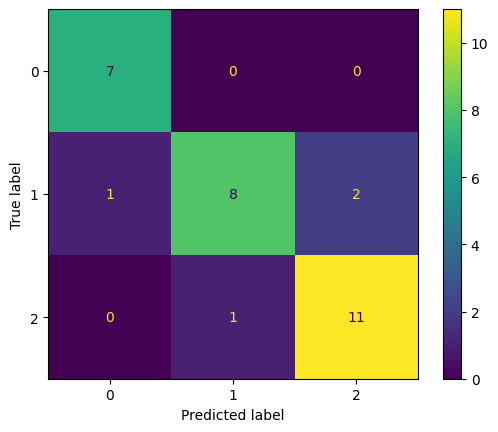

In [16]:
acc = accuracy_score(y_true=y_test, y_pred=y_pred)

confusion = ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred)).plot()

print("RGB NormalWeights")
print("Accuracy :",acc,"\n")
print(classification_report(y_true=y_test, y_pred=y_pred))
# plt.savefig("confusionmatrix_RGB_model1.png")

In [17]:
print("Predicted",y_pred)
print("True     ",list(y_test))

Predicted [0, 0, 2, 1, 2, 0, 0, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 0, 2, 2]
True      [0, 1, 2, 2, 2, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 0, 1, 2]


### HSV + LAB + LUV

In [18]:
model1 = load_model('models/IncRes_HSV+Contrast_model1.hdf5')
model1.load_weights('best_weights/IncRes_HSV+Contrast_model1.hdf5')
model2 = load_model('models/IncRes_LAB+contrast_model1.hdf5')
model2.load_weights('best_weights/IncRes_LAB+contrast_model1.hdf5')
model3 = load_model('models/IncRes_LUV+contrast_model1.hdf5')
model3.load_weights('best_weights/IncRes_LUV+contrast_model1.hdf5')
models = [model1, model2, model3]
model_space = ['HSV', 'LAB', 'LUV']

In [19]:
y_pred = []
counter = 0
for i,image_path in enumerate(x_test):
    probs = []       
    predictions,preds = predictor(image_path,model_space)  
    c = 0    
    for j,pred in enumerate(predictions):
        class_pred = classes.index(pred)  
        print("True:",classes[y_test[i]]," Predicted:",pred)
        if classes[y_test[i]] == pred:
            print("True:",classes[y_test[i]]," Predicted:",pred,class_pred)
            y_pred.append(class_pred)
            c = 1
            counter += 1
            break
    if c == 0:
        y_pred.append(classes.index(predictions[0]))
print("counter",counter,"/ 30")

Space: HSV
HSV
1/1 [==============================] - 1s 1s/step
Space: LAB
LAB
1/1 [==============================] - 1s 1s/step
Space: LUV
LUV
1/1 [==============================] - 1s 1s/step
Probs : [0.9999997, 3.6811835e-07, 4.3972235e-09]
True: Healthy  Predicted: Healthy
True: Healthy  Predicted: Healthy 0
Space: HSV
HSV
1/1 [==============================] - 0s 23ms/step
Space: LAB
LAB
1/1 [==============================] - 0s 21ms/step
Space: LUV
LUV
1/1 [==============================] - 0s 20ms/step
Probs : [0.33594206, 2.1251524e-06, 0.66405576]
True: Sprayable  Predicted: Non Sprayable
True: Sprayable  Predicted: Healthy
Space: HSV
HSV
1/1 [==============================] - 0s 22ms/step
Space: LAB
LAB
1/1 [==============================] - 0s 23ms/step
Space: LUV
LUV
1/1 [==============================] - 0s 22ms/step
Probs : [0.00015736262, 0.49462762, 0.505215]
True: Non Sprayable  Predicted: Non Sprayable
True: Non Sprayable  Predicted: Non Sprayable 2
Space: HSV
HSV
1/

1/1 [==============================] - 0s 20ms/step
Space: LUV
LUV
1/1 [==============================] - 0s 20ms/step
Probs : [0.33357707, 0.1661845, 0.5002384]
True: Sprayable  Predicted: Non Sprayable
True: Sprayable  Predicted: Healthy
Space: HSV
HSV
1/1 [==============================] - 0s 21ms/step
Space: LAB
LAB
1/1 [==============================] - 0s 20ms/step
Space: LUV
LUV
1/1 [==============================] - 0s 20ms/step
Probs : [0.9970682, 1.7415206e-05, 0.0029143381]
True: Healthy  Predicted: Healthy
True: Healthy  Predicted: Healthy 0
Space: HSV
HSV
1/1 [==============================] - 0s 20ms/step
Space: LAB
LAB
1/1 [==============================] - 0s 20ms/step
Space: LUV
LUV
1/1 [==============================] - 0s 21ms/step
Probs : [5.155746e-05, 0.22832024, 0.7716282]
True: Sprayable  Predicted: Non Sprayable
True: Sprayable  Predicted: Sprayable
True: Sprayable  Predicted: Sprayable 1
Space: HSV
HSV
1/1 [==============================] - 0s 21ms/step
Space:

RGB NormalWeights
Accuracy : 0.6666666666666666 

              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       1.00      0.18      0.31        11
           2       0.60      1.00      0.75        12

    accuracy                           0.67        30
   macro avg       0.78      0.68      0.62        30
weighted avg       0.78      0.67      0.60        30



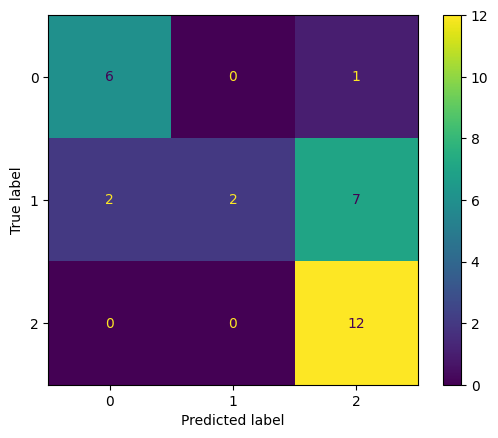

In [20]:
acc = accuracy_score(y_true=y_test, y_pred=y_pred)

confusion = ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred)).plot()

print("RGB NormalWeights")
print("Accuracy :",acc,"\n")
print(classification_report(y_true=y_test, y_pred=y_pred))
# plt.savefig("confusionmatrix_RGB_model1.png")

In [21]:
print("Predicted",y_pred)
print("True     ",list(y_test))

Predicted [0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 0, 1, 0, 2, 2]
True      [0, 1, 2, 2, 2, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 0, 1, 2]


### HLS + LUV + HSV

In [22]:
model1 = load_model('models/IncRes_HLS_model1.hdf5')
model1.load_weights('best_weights/IncRes_HLS_model1.hdf5')
model2 = load_model('models/IncRes_LUV+contrast_model1.hdf5')
model2.load_weights('best_weights/IncRes_LUV+contrast_model1.hdf5')
model3 = load_model('models/IncRes_HSV+Contrast_model1.hdf5')
model3.load_weights('best_weights/IncRes_HSV+Contrast_model1.hdf5')
models = [model1, model2, model3]
model_space = ['HLS', 'LUV', 'HSV']

In [23]:
y_pred = []
counter = 0
for i,image_path in enumerate(x_test):
    probs = []       
    predictions,preds = predictor(image_path,model_space)  
    c = 0    
    for j,pred in enumerate(predictions):
        class_pred = classes.index(pred)  
        print("True:",classes[y_test[i]]," Predicted:",pred)
        if classes[y_test[i]] == pred:
            print("True:",classes[y_test[i]]," Predicted:",pred,class_pred)
            y_pred.append(class_pred)
            c = 1
            counter += 1
            break
    if c == 0:
        y_pred.append(classes.index(predictions[0]))
print("counter",counter,"/ 30")

Space: HLS
HLS
1/1 [==============================] - 1s 1s/step
Space: LUV
LUV
1/1 [==============================] - 1s 1s/step
Space: HSV
HSV
1/1 [==============================] - 1s 1s/step
Probs : [0.9965213, 0.00060039904, 0.0028782815]
True: Healthy  Predicted: Healthy
True: Healthy  Predicted: Healthy 0
Space: HLS
HLS
1/1 [==============================] - 0s 21ms/step
Space: LUV
LUV
1/1 [==============================] - 0s 20ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 20ms/step
Probs : [0.5927903, 0.00900405, 0.39820567]
True: Sprayable  Predicted: Healthy
True: Sprayable  Predicted: Non Sprayable
Space: HLS
HLS
1/1 [==============================] - 0s 22ms/step
Space: LUV
LUV
1/1 [==============================] - 0s 20ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 20ms/step
Probs : [0.032911044, 0.44022283, 0.52686614]
True: Non Sprayable  Predicted: Non Sprayable
True: Non Sprayable  Predicted: Non Sprayable 2
Space: HLS
HLS
1/1 [==

1/1 [==============================] - 0s 22ms/step
Probs : [2.701155e-06, 0.532437, 0.46756038]
True: Sprayable  Predicted: Sprayable
True: Sprayable  Predicted: Sprayable 1
Space: HLS
HLS
1/1 [==============================] - 0s 21ms/step
Space: LUV
LUV
1/1 [==============================] - 0s 22ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 21ms/step
Probs : [0.48840308, 0.16627799, 0.3453189]
True: Sprayable  Predicted: Healthy
True: Sprayable  Predicted: Non Sprayable
Space: HLS
HLS
1/1 [==============================] - 0s 20ms/step
Space: LUV
LUV
1/1 [==============================] - 0s 20ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 21ms/step
Probs : [0.98931104, 0.001128651, 0.009560334]
True: Healthy  Predicted: Healthy
True: Healthy  Predicted: Healthy 0
Space: HLS
HLS
1/1 [==============================] - 0s 20ms/step
Space: LUV
LUV
1/1 [==============================] - 0s 20ms/step
Space: HSV
HSV
1/1 [==============================

RGB NormalWeights
Accuracy : 0.7666666666666667 

              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       0.83      0.45      0.59        11
           2       0.85      0.92      0.88        12

    accuracy                           0.77        30
   macro avg       0.77      0.79      0.75        30
weighted avg       0.79      0.77      0.75        30



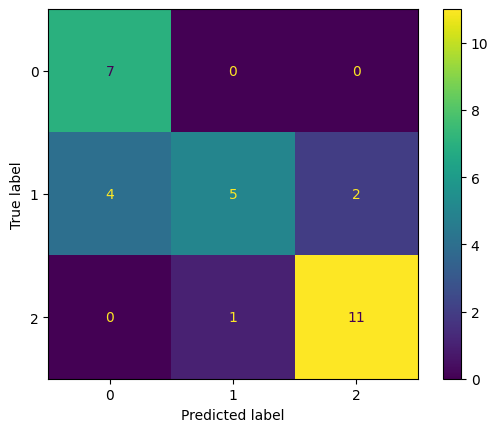

In [24]:
acc = accuracy_score(y_true=y_test, y_pred=y_pred)

confusion = ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred)).plot()

print("RGB NormalWeights")
print("Accuracy :",acc,"\n")
print(classification_report(y_true=y_test, y_pred=y_pred))
# plt.savefig("confusionmatrix_RGB_model1.png")

In [25]:
print("Predicted",y_pred)
print("True     ",list(y_test))

Predicted [0, 0, 2, 1, 2, 0, 0, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 0, 1, 0, 2, 2]
True      [0, 1, 2, 2, 2, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 0, 1, 2]


### HLS + LAB + HSV

In [26]:
model1 = load_model('models/IncRes_HLS_model1.hdf5')
model1.load_weights('best_weights/IncRes_HLS_model1.hdf5')
model2 = load_model('models/IncRes_LAB+contrast_model1.hdf5')
model2.load_weights('best_weights/IncRes_LAB+contrast_model1.hdf5')
model3 = load_model('models/IncRes_HSV+Contrast_model1.hdf5')
model3.load_weights('best_weights/IncRes_HSV+Contrast_model1.hdf5')
models = [model1, model2, model3]
model_space = ['HLS', 'LAB', 'HSV']

In [27]:
y_pred = []
counter = 0
for i,image_path in enumerate(x_test):
    probs = []       
    predictions,preds = predictor(image_path,model_space)  
    c = 0    
    for j,pred in enumerate(predictions):
        class_pred = classes.index(pred)  
        print("True:",classes[y_test[i]]," Predicted:",pred)
        if classes[y_test[i]] == pred:
            print("True:",classes[y_test[i]]," Predicted:",pred,class_pred)
            y_pred.append(class_pred)
            c = 1
            counter += 1
            break
    if c == 0:
        y_pred.append(classes.index(predictions[0]))
print("counter",counter,"/ 30")

Space: HLS
HLS
1/1 [==============================] - 2s 2s/step
Space: LAB
LAB
1/1 [==============================] - 1s 1s/step
Space: HSV
HSV
1/1 [==============================] - 1s 1s/step
Probs : [0.99652165, 0.0006000348, 0.0028782787]
True: Healthy  Predicted: Healthy
True: Healthy  Predicted: Healthy 0
Space: HLS
HLS
1/1 [==============================] - 0s 21ms/step
Space: LAB
LAB
1/1 [==============================] - 0s 23ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 21ms/step
Probs : [0.5900307, 0.00900395, 0.4009653]
True: Sprayable  Predicted: Healthy
True: Sprayable  Predicted: Non Sprayable
Space: HLS
HLS
1/1 [==============================] - 0s 21ms/step
Space: LAB
LAB
1/1 [==============================] - 0s 20ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 21ms/step
Probs : [0.032916415, 0.2899619, 0.6771217]
True: Non Sprayable  Predicted: Non Sprayable
True: Non Sprayable  Predicted: Non Sprayable 2
Space: HLS
HLS
1/1 [=====

1/1 [==============================] - 0s 20ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 21ms/step
Probs : [2.7082233e-06, 0.5349063, 0.46509108]
True: Sprayable  Predicted: Sprayable
True: Sprayable  Predicted: Sprayable 1
Space: HLS
HLS
1/1 [==============================] - 0s 20ms/step
Space: LAB
LAB
1/1 [==============================] - 0s 20ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 20ms/step
Probs : [0.65677804, 0.16715832, 0.17606366]
True: Sprayable  Predicted: Healthy
True: Sprayable  Predicted: Non Sprayable
True: Sprayable  Predicted: Sprayable
True: Sprayable  Predicted: Sprayable 1
Space: HLS
HLS
1/1 [==============================] - 0s 21ms/step
Space: LAB
LAB
1/1 [==============================] - 0s 21ms/step
Space: HSV
HSV
1/1 [==============================] - 0s 21ms/step
Probs : [0.98932123, 0.001128648, 0.009550136]
True: Healthy  Predicted: Healthy
True: Healthy  Predicted: Healthy 0
Space: HLS
HLS
1/1 [================

RGB NormalWeights
Accuracy : 0.9 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.73      0.84        11
           2       0.86      1.00      0.92        12

    accuracy                           0.90        30
   macro avg       0.91      0.91      0.90        30
weighted avg       0.91      0.90      0.90        30



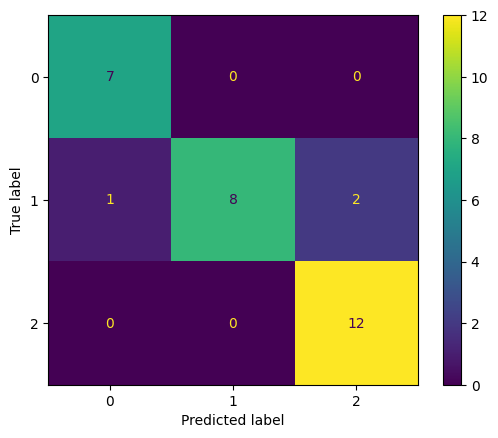

In [28]:
acc = accuracy_score(y_true=y_test, y_pred=y_pred)

confusion = ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred)).plot()

print("RGB NormalWeights")
print("Accuracy :",acc,"\n")
print(classification_report(y_true=y_test, y_pred=y_pred))
# plt.savefig("confusionmatrix_RGB_model1.png")

In [29]:
print("Predicted",y_pred)
print("True     ",list(y_test))

Predicted [0, 0, 2, 2, 2, 0, 0, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 0, 2, 2]
True      [0, 1, 2, 2, 2, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 0, 1, 2]
